# Welcome  

Notebook Author: Samuel Alter  
Notebook Subject: Capstone Project - Image Analysis

BrainStation Winter 2023: Data Science

This notebook is for running my satellite images through deep learning networks. The images have been pre-processed in a separate notebook.

The goal is to find a pre-trained CNN to adapt to our specific use-case of finding insights about wildfire-prone landscapes.

## Imports

In [87]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import shutil
from PIL import Image
import cv2

## Split all 7760 images in to `train` and `test` splits

In [138]:
def createTVTS(start,total_img:int,step=1,
              valid_frac=0.15,test_frac=0.15,
              replace=False,verbose=True,debug=False):
    '''
    Creates three lists for a train/validation/test split of 
    numbered files, such as patches previously made from 
    a larger image to be used in convolutional neural network 
    workflows.
    
    The training fraction of the output is the remainder of
    the sum of the validation fraction and the testing fraction:
    
    train_frac = 1 - (valid_frac + test_frac)
    
    Default splits are:
        0.7    = 1 - (   .15     +    .15 )
    
    Please ensure that you have a reasonable split amongst these
    three groups.
    
    ----
    Inputs:
    
    >start
    starting number for the image patches
    
    >total_img
    serves both as total size of images in the patch set
    
    >step
    defaults to 1, the step size in creating a list of numbers
    
    >valid_frac
    the fraction of the numbers that will be split into the
    validation set. Please make the number between 0 and 1
    
    >train_frac
    the fraction of the numbers that will be split into the
    training set. Please make the number between 0 and 1
    
    >replace
    since this function is splitting the numbers, replace defaults
    to False
    
    >verbose
    runs a line of code to check that the splitting was successful
    
    >debug
    helpful print statements to show you what step function is on.
    defaults to not showing these statements
    
    ----
    Outputs:
    
    >train_valid_test_tuple
    a tuple of three lists, containing the train, valid, and
    test list that when combined together are the same size as
    the total_img value
    
    '''
#     create list with each image's number
#     there are `total_img` images each in the fire and nofire datasets
    file_nums=np.arange(start,total_img,step)
    if debug==True:
        print(f'created initial list of size {total_img}')
        
#     create train fraction
    train_frac=1-(valid_frac+test_frac)
    if debug==True:
        print(f'created train_fraction ({train_frac})')
    
#     create train, valid, and test splits    
    trains = np.random.choice(file_nums,
                              size=int(total_img * train_frac),
                              replace=False)
    if debug==True:
        print('created train list')
    
    valids = np.random.choice(np.setdiff1d(file_nums, trains),
                              size=int(total_img * valid_frac),
                              replace=False)
    if debug==True:
        print('created validation list')
    
    tests = np.random.choice(np.setdiff1d(file_nums, np.concatenate((trains, valids))),
                             size=int(total_img * test_frac),
                             replace=False)
    if debug==True:
        print('created test list')
    
    # tests=list(set(file_nums)-set(trains))

    if verbose==True:
        print(f'The size of train ({len(trains)}), validation ({len(valids)}), and tests ({len(tests)}) together is {len(trains)+len(valids)+len(tests)}')
        if debug==True:
            print('printed size of train, validation, and test')
            
    train_valid_test_tuple=(trains,tests,valids)
    if debug==True:
         print('created tuple of train, validation, and test')
    
    return train_valid_test_tuple

In [139]:
# run function

train_valid_test_tuple=createTVTS(start=0,total_img=7760,\
                           step=1,verbose=True,\
                           debug=True)
# train_valid_test_tuple

# sanity checks
trains=train_valid_test_tuple[0]
valids=train_valid_test_tuple[1]
tests=train_valid_test_tuple[2]

print(len(trains))
print(len(valids))
print(len(tests))

print(set(trains) & set(valids) & set(tests))

created initial list of size 7760
created train_fraction (0.7)
created train list
created validation list
created test list
The size of train (5432), validation (1164), and tests (1164) together is 7760
printed size of train, validation, and test
created tuple of train, validation, and test
5432
1164
1164
set()


In [140]:
trains

array([1179, 5283, 7319, ..., 4356, 5760, 3943])

In [141]:
# convert list of integers to list of strings
# important for moving files in next step
trains=[str(i) for i in trains]
valids=[str(i) for i in valids]
tests=[str(i) for i in tests]

type(trains[0])

str

### Move the images to their corresponding training and validation locations

In [142]:
def copyFileByNumber(source, dest, set_):
    '''
    Copies files from `source` to `dest` that have numbers 
    in their filename and that match any element in `set_` 
    list (either trains, valids, or tests).
    
    ----
    Inputs:
    
    >source
    source of files to be copied
    
    >dest
    destination of files to be moved to
    
    >set_
    specify either the training ('trains'), validation
    ('valids') or test ('tests') set
    
    ----
    Outputs:
    
    >N/A
    copies files, no further output
    
    '''
    
    for filename in os.listdir(source):
        # Get the number in the filename
        file_num = "".join(filter(str.isdigit, filename))
        # Check if the number is in the trains list
        if file_num in set_:
            # Copy the file to the destination folder
            shutil.copy(os.path.join(source, filename), dest)

In [143]:
def filePresenceSumChecker(directory:str,extension:str,verbose=False):
    '''
    Checks the sum of all the files with a certain extension.
    
    Useful to see if a file move process has already been completed.
    
    ----
    Inputs
    
    >directory
    path to a folder to check if files are there
    
    >extension
    user-specified extension to only count those files
    
    ----
    Outputs
    
    >counter
    gives the amount of files within the directory
    '''
    
    counter=0
    
    # get a list of all files in the directory
    files = os.listdir(directory)

    # iterate through the files and check if any have the specified extension
    for file in files:
        if file.endswith(extension):
            counter+=1
                
    if verbose==True:
        print(f"There are {counter} '{extension}' files within {directory}.")

    return counter

In [144]:
# setup loop for copyFileByNumber

source_train_fire='/Users/sra/Desktop/Data_Science_2023/_capstone/00_capstone_data/orthoimagery/patches/patch_fire'
source_train_nofire='/Users/sra/Desktop/Data_Science_2023/_capstone/00_capstone_data/orthoimagery/patches/patch_nofire'
source_valid_fire='/Users/sra/Desktop/Data_Science_2023/_capstone/00_capstone_data/orthoimagery/patches/patch_fire'
source_valid_nofire='/Users/sra/Desktop/Data_Science_2023/_capstone/00_capstone_data/orthoimagery/patches/patch_nofire'
source_test_fire='/Users/sra/Desktop/Data_Science_2023/_capstone/00_capstone_data/orthoimagery/patches/patch_fire'
source_test_nofire='/Users/sra/Desktop/Data_Science_2023/_capstone/00_capstone_data/orthoimagery/patches/patch_nofire'


dest_train_fire='/Users/sra/Desktop/Data_Science_2023/_capstone/00_capstone_data/orthoimagery/patches/train/fire'
dest_train_nofire='/Users/sra/Desktop/Data_Science_2023/_capstone/00_capstone_data/orthoimagery/patches/train/nofire'
dest_valid_fire='/Users/sra/Desktop/Data_Science_2023/_capstone/00_capstone_data/orthoimagery/patches/validation/fire'
dest_valid_nofire='/Users/sra/Desktop/Data_Science_2023/_capstone/00_capstone_data/orthoimagery/patches/validation/nofire'
dest_test_fire='/Users/sra/Desktop/Data_Science_2023/_capstone/00_capstone_data/orthoimagery/patches/test/fire'
dest_test_nofire='/Users/sra/Desktop/Data_Science_2023/_capstone/00_capstone_data/orthoimagery/patches/test/nofire'


sources = [source_train_fire,
          source_train_nofire,
          source_valid_fire,
          source_valid_nofire,
          source_test_fire,
          source_test_nofire]

dests = [dest_train_fire,
        dest_train_nofire,
        dest_valid_fire,
        dest_valid_nofire,
        dest_test_fire,
        dest_test_nofire]

sets = [trains,
        trains,
        valids,
        valids,
        tests,
        tests]

In [147]:
# run function to move subsets of patches
# flow control
if filePresenceSumChecker(directory=dests[0],extension='.tif')==0:
    for src,des,sts in zip(sources,dests,sets):
        copyFileByNumber(source=src,dest=des,set_=sts)

### Rename files and change to proper format

Convert filenames from `patch_fire.X.tif` to `patch_fire_X.tif`, where X is a number with one or more digits.

In [148]:
def fileRenamer(source:str, prefix:str,extension='.tif'):
    '''
    Renames files to the format provided by the user.
    It can help clean an image format to one that can be
    read by modules like Tensorflow.
    
    ----
    Inputs:
    
    >source
    the directory where the files are located
    
    >prefix
    the base part of the filename that will remain
    
    >extension
    defaults to '.tif', but this will ensure you only rename
    certain files that have the specified extension
    
    ----
    Outputs:
    
    >N/A
    renames files in-place, no further output
    '''

    # loop over each file from the source directory
    for filename in os.listdir(source):
        
        # check if the file is the provided `ext` (extension)
        if filename.endswith(extension):
            
            # split the filename into base and extension
            base, ext = os.path.splitext(filename)
            
            # split the base into the prefix and number parts
            prefix, number = base.split('.', 1)
            
            # create the new filename with the desired format
            new_filename = f'{prefix}_{number}{ext}'
            
            # rename the file
            os.rename(os.path.join(source, filename), 
                      os.path.join(source, new_filename))

In [152]:
# make a for loop to rename all the files

source_train_fire='/Users/sra/Desktop/Data_Science_2023/_capstone/00_capstone_data/orthoimagery/patches/train/fire'
source_train_nofire='/Users/sra/Desktop/Data_Science_2023/_capstone/00_capstone_data/orthoimagery/patches/train/nofire'
source_valid_fire='/Users/sra/Desktop/Data_Science_2023/_capstone/00_capstone_data/orthoimagery/patches/validation/fire'
source_valid_nofire='/Users/sra/Desktop/Data_Science_2023/_capstone/00_capstone_data/orthoimagery/patches/validation/nofire'
source_test_fire='/Users/sra/Desktop/Data_Science_2023/_capstone/00_capstone_data/orthoimagery/patches/test/fire'
source_test_nofire='/Users/sra/Desktop/Data_Science_2023/_capstone/00_capstone_data/orthoimagery/patches/test/nofire'


sources=[source_train_fire,
        source_train_nofire,
        source_valid_fire,
        source_valid_nofire,
        source_test_fire,
        source_test_nofire]
 
# flow control
if filePresenceSumChecker(directory=source_train_fire,extension='.tif')<0:
    for src in sources:    
        fileRenamer(source=src,prefix='patch_fire')

Convert .tif images to .jpg for `ImageDataGenerator`

In [155]:
def imageConverter(inputPath, outputPath, oldExtension='.tif',newExtension='.jpg',fileType='JPEG',verbose=False):
    '''
    Iterates through a directory of (default) .tif files and 
    converts them to (default) .jpg format using Pillow library.

    Requires an input directory path 
    and an output directory path as strings.
    
    ----
    Inputs:
    
    >inputPath
    string path to where the inputs are located
    
    >outputPath
    string path to where the outputs will be located
    '''

    # create the output directory if it doesn't exist
    # os.makedirs(outputPath, exist_ok=True)

    # iterate through all files in the input directory
    for file_name in os.listdir(inputPath):
        if file_name.endswith(oldExtension):
            # construct the input and output file paths
            input_path = os.path.join(inputPath, file_name)
            output_path = os.path.join(outputPath, 
                                       file_name.replace(oldExtension,
                                                         newExtension))

            # load the image
            # https://stackoverflow.com/questions/40751523/how-do-you-read-a-32-bit-tiff-image-in-python
            img = cv2.imread(input_path,-1)
            
            # convert to RGB format if necessary
            if img.shape[2] == 1:
                img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
            elif img.shape[2] == 4:
                img = cv2.cvtColor(img, cv2.COLOR_BGRA2RGB)

            # Save the image as a .jpg file
            cv2.imwrite(output_path, img, [int(cv2.IMWRITE_JPEG_QUALITY), 90])
            
            if verbose==True:
                print(f"Conversion complete: {input_path} -> {output_path}")


In [156]:
directory = '/Users/sra/Desktop/Data_Science_2023/_capstone/00_capstone_data/orthoimagery/patches/validation/nofire'
extension = '.jpg'

filePresenceSumChecker(directory=directory,extension=extension)

0

In [157]:
# setup for loop

inputPath_train_fire='/Users/sra/Desktop/Data_Science_2023/_capstone/00_capstone_data/orthoimagery/patches/train/fire'
inputPath_train_nofire='/Users/sra/Desktop/Data_Science_2023/_capstone/00_capstone_data/orthoimagery/patches/train/nofire'
inputPath_valid_fire='/Users/sra/Desktop/Data_Science_2023/_capstone/00_capstone_data/orthoimagery/patches/validation/fire'
inputPath_valid_nofire='/Users/sra/Desktop/Data_Science_2023/_capstone/00_capstone_data/orthoimagery/patches/validation/nofire'
inputPath_test_fire='/Users/sra/Desktop/Data_Science_2023/_capstone/00_capstone_data/orthoimagery/patches/test/fire'
inputPath_test_nofire='/Users/sra/Desktop/Data_Science_2023/_capstone/00_capstone_data/orthoimagery/patches/test/nofire'


outputPath_train_fire='/Users/sra/Desktop/Data_Science_2023/_capstone/00_capstone_data/orthoimagery/patches/train/fire'
outputPath_train_nofire='/Users/sra/Desktop/Data_Science_2023/_capstone/00_capstone_data/orthoimagery/patches/train/nofire'
outputPath_valid_fire='/Users/sra/Desktop/Data_Science_2023/_capstone/00_capstone_data/orthoimagery/patches/validation/fire'
outputPath_valid_nofire='/Users/sra/Desktop/Data_Science_2023/_capstone/00_capstone_data/orthoimagery/patches/validation/nofire'
outputPath_test_fire='/Users/sra/Desktop/Data_Science_2023/_capstone/00_capstone_data/orthoimagery/patches/test/fire'
outputPath_test_nofire='/Users/sra/Desktop/Data_Science_2023/_capstone/00_capstone_data/orthoimagery/patches/test/nofire'


inputPaths=[inputPath_train_fire,
            inputPath_train_nofire,
            inputPath_valid_fire,
            inputPath_valid_nofire,
            inputPath_test_fire,
            inputPath_test_nofire]

outputPaths=[outputPath_train_fire,
            outputPath_train_nofire,
            outputPath_valid_fire,
            outputPath_valid_nofire,
            outputPath_test_fire,
            outputPath_test_nofire]

In [158]:
# flow control
if filePresenceSumChecker(directory=outputPath_train_fire,extension='.jpg')==0:
    for inp,outp in zip(inputPaths,outputPaths):
        imageConverter(inputPath=inp,outputPath=outp)

In [159]:
filePresenceSumChecker(directory='/Users/sra/Desktop/Data_Science_2023/_capstone/00_capstone_data/orthoimagery/patches/validation/fire',
                      extension='.jpg')

1164

In [160]:
def fileDeleter(source:str, extension:str='.tif'):
    '''
    Deletes files with the provided extension from the source directory.
    
    ----
    Inputs:
    
    >source
    the directory where the files are located
    
    >extension
    defaults to '.tif', but this will ensure you only delete
    certain files that have the specified extension
    
    ----
    Outputs:
    
    >N/A
    deletes files in-place, no further output
    '''
    
    # loop over each file from the source directory
    for filename in os.listdir(source):
        
        # check if the file is the provided `ext` (extension)
        if filename.endswith(extension):
            
            # delete the file
            os.remove(os.path.join(source, filename))


In [163]:
# setup for loop

inputPath_train_fire='/Users/sra/Desktop/Data_Science_2023/_capstone/00_capstone_data/orthoimagery/patches/train/fire'
inputPath_train_nofire='/Users/sra/Desktop/Data_Science_2023/_capstone/00_capstone_data/orthoimagery/patches/train/nofire'
inputPath_valid_fire='/Users/sra/Desktop/Data_Science_2023/_capstone/00_capstone_data/orthoimagery/patches/validation/fire'
inputPath_valid_nofire='/Users/sra/Desktop/Data_Science_2023/_capstone/00_capstone_data/orthoimagery/patches/validation/nofire'
inputPath_test_fire='/Users/sra/Desktop/Data_Science_2023/_capstone/00_capstone_data/orthoimagery/patches/test/fire'
inputPath_test_nofire='/Users/sra/Desktop/Data_Science_2023/_capstone/00_capstone_data/orthoimagery/patches/test/nofire'

inputPaths=[inputPath_train_fire,
            inputPath_train_nofire,
            inputPath_valid_fire,
            inputPath_valid_nofire,
            inputPath_test_fire,
            inputPath_test_nofire]

In [164]:
# flow control
if filePresenceSumChecker(directory=inputPath_train_fire,extension='.tif')>0:
    for inp in (inputPaths):
        fileDeleter(source=inp)

## Run the models: `VGG19` and `ResNet50v2`

### `VGG19`

#### Setup `VGG19`

In [195]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

##### Notes

**Adapted from**
https://stackoverflow.com/questions/42443936/keras-split-train-test-set-when-using-imagedatagenerator

**And**
https://www.tensorflow.org/tutorials/keras/save_and_load

In [196]:
# import `ImageDataGenerator` to help facilitate 
# loading images directly from our computer
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [197]:
# use earlystopping to control if epoch length goes for too long
# https://stackoverflow.com/questions/45185462/what-does-nb-epoch-in-neural-network-stands-for
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=4, mode='auto')

# checkpoint callback
checkpoint_path = '/Users/sra/Desktop/Data_Science_2023/_capstone/00_capstone_data/models/_sam_vgg19/model_checkpoints'
checkpoint_dir = os.path.dirname(checkpoint_path)

# Specify the dimensions for the target preprocess image size
# and the variable definitions used below
img_height = 128 
img_width = 128
channels = 3
batch_size = 32
train_data_dir = '/Users/sra/Desktop/Data_Science_2023/_capstone/00_capstone_data/orthoimagery/patches/train'
test_data_dir = '/Users/sra/Desktop/Data_Science_2023/_capstone/00_capstone_data/orthoimagery/patches/test'

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    verbose=1,
    save_freq=5*batch_size)

# instantiate training image data generator
train_datagen = ImageDataGenerator(rescale=1./255,
    shear_range=0.2,
    horizontal_flip=True,
    validation_split=0.2) # set validation split

test_datagen=ImageDataGenerator(rescale=1./255)

test_generator=test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_height, img_width),
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical')

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training') # set as training data

validation_generator = train_datagen.flow_from_directory(
    train_data_dir, # same directory as training data
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation') # set as validation data

X_test, y_test = test_generator.next()

Found 2328 images belonging to 2 classes.
Found 8692 images belonging to 2 classes.
Found 2172 images belonging to 2 classes.


In [198]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense

height = 128 
width = 128
channels = 3

res_model = VGG19(weights='imagenet',
                  include_top=False,
                  input_shape=(height,width,channels),
                  pooling='avg')

# Freeze all the layers in the base model
for layer in res_model.layers:
    layer.trainable = False

In [199]:
# because we are focused on two classes (fire/nofire), add a new
# final output layer with 2 nodes and a sigmoid activation function
x = Dense(2, activation="softmax", name="output_")(res_model.output)
res_model = Model(inputs=res_model.input, outputs=x)

#https://stackoverflow.com/questions/59100865/trying-to-append-a-dense-layer-to-vgg19-network

# print(res_model.summary())

Visualize the classes:

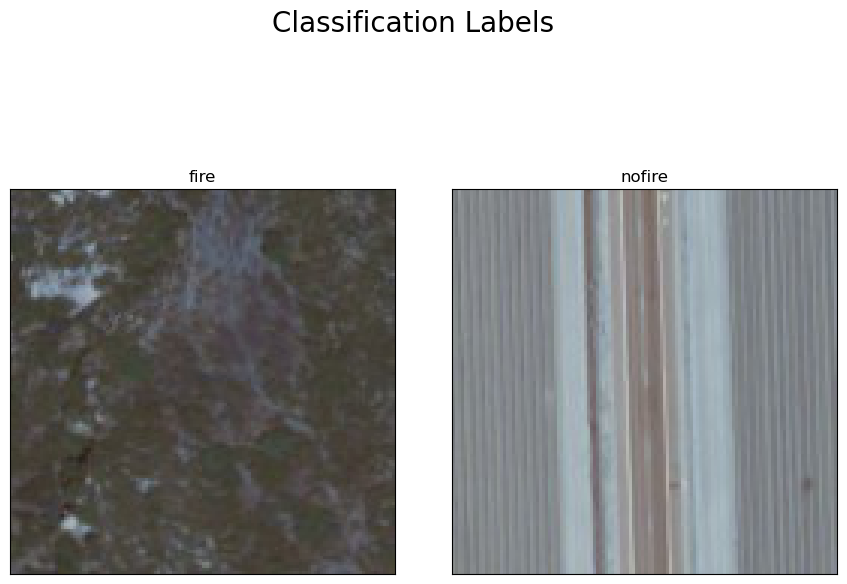

In [200]:
# Grab a batch of images from our validation generator: 
x, y = validation_generator.next() 

# Our images labels are one-hot encoded, lets 
# convert them to ordinal encoding
labels = np.argmax(y, axis=1)

landscape_classes = ['fire','nofire']

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(9, 14))
ax = ax.flatten()

for i in range(2):
    index = np.argmax(labels==i) 
    ax[i].imshow(x[index])
    
    # Set the title of the subplot
    ax[i].set_title(landscape_classes[i])
    
    # Hide the x and y ticks
    ax[i].set_xticks([]) 
    ax[i].set_yticks([])
    

fig.suptitle("Classification Labels", size = 20)
fig.tight_layout()

# Delete the two unused subplots
fig.delaxes(ax[-1])
fig.delaxes(ax[-2])

plt.show()

#### Run `VGG19` model

In [201]:
# compile VGG19 model
# adapted from
# https://github.com/ZeeTsing/Dogs_breed_classification/blob/master/3_inceptionres_best.ipynb
import tensorflow as tf

adam = tf.keras.optimizers.Adam(learning_rate=0.001)

num_classes=2

res_model.compile(optimizer = adam, 
              loss = 'binary_crossentropy', 
              metrics=['accuracy'])

# save the weights using the `checkpoint_path` format
res_model.save_weights(checkpoint_path.format(epoch=0))

history=res_model.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // batch_size,
    epochs = 30,
    verbose = True,
    callbacks = [early_stopping,cp_callback]) #early stop and checkpoints

# save the model
res_model.save('/Users/sra/Desktop/Data_Science_2023/_capstone/00_capstone_data/models/_sam_vgg19/vgg19_20230330.h5')

Epoch 1/30
159/271 [================>.............] - ETA: 2:15 - loss: 0.4694 - accuracy: 0.8668
Epoch 00001: saving model to /Users/sra/Desktop/Data_Science_2023/_capstone/00_capstone_data/models/_sam_vgg19/model_checkpoints
271/271 [==============================] - 428s 2s/step - loss: 0.3942 - accuracy: 0.8878 - val_loss: 0.5855 - val_accuracy: 0.6320
Epoch 2/30
 48/271 [====>.........................] - ETA: 5:10 - loss: 0.2564 - accuracy: 0.9154
Epoch 00002: saving model to /Users/sra/Desktop/Data_Science_2023/_capstone/00_capstone_data/models/_sam_vgg19/model_checkpoints
208/271 [======================>.......] - ETA: 1:55 - loss: 0.2236 - accuracy: 0.9243
Epoch 00002: saving model to /Users/sra/Desktop/Data_Science_2023/_capstone/00_capstone_data/models/_sam_vgg19/model_checkpoints
271/271 [==============================] - 731s 3s/step - loss: 0.2160 - accuracy: 0.9248 - val_loss: 0.4637 - val_accuracy: 0.6889
Epoch 3/30
 97/271 [=========>....................] - ETA: 7:06 - 

##### Load model from checkpoint

In [202]:
loaded_model=keras.models.load_model('/Users/sra/Desktop/Data_Science_2023/_capstone/00_capstone_data/models/_sam_vgg19/vgg19_20230330.h5')

In [203]:
loaded_model.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0  

#### Evaluate 'VGG19' model

In [205]:
# save the entire model as a SavedModel
# !mkdir -p saved_moderes_models_model.save('/Users/sra/Desktop/Data_Science_2023/_capstone/00_capstone_data/models/_sam_vgg19/saved_model/vgg19_01')

# # review resulting checkpoints
# os.listdir(checkpoint_dir)

# # choose latest checkpoint
# latest = tf.train.latest_checkpoint(checkpoint_dir)
# latest

# # reload fresh Keras model from saved model
# new_model = tf.keras.models.load_model('saved_model/my_model')

# # Check its architecture
# new_model.summary()

# check its accuracy
loss, acc = loaded_model.evaluate(test_generator, landscape_classes, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

ValueError: `y` argument is not supported when using `keras.utils.Sequence` as input.

In [58]:
# flow control
counter=1
if counter==1:
    score = res_model.evaluate(validation_data, verbose=1)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    counter=1

NameError: name 'validation_data' is not defined

##### Calculate the predictions

In [ ]:
predict_probas = model.predict(X_test)

# Convert probabilities to label encoding
y_predict = np.argmax(predict_probas, axis=1)

##### Convert test labels from one-hot encoding to label encoding

In [56]:
y_test_labels = np.argmax(y_test, axis=1)

conf_mat = confusion_matrix(y_test_labels, y_predict)
normalized_conf_mat = conf_mat / conf_mat.sum(axis=1)

plt.figure(figsize = (8,6))
sns.heatmap(normalized_conf_mat,
            annot=True,
            cbar=False,
            xticklabels=landscape_classes,
            yticklabels=landscape_classes,
            cmap="rocket_r",
            linewidths=1,
            
           )
plt.title('Confusion Matrix',size = 25,y=1.01)
plt.xlabel("Predicted Label", size = 20)
plt.ylabel("True Label", size = 20)
plt.show()

NameError: name 'y_test' is not defined

##### Incorrectly predicted images

In [55]:
import math

incorrect_photos = y_test_labels != y_predict

num_images = np.count_nonzero(incorrect_photos)
columns = 3
rows = math.ceil(num_images / columns)

fig, axes = plt.subplots(nrows=rows, ncols=columns, figsize=(10, 3.5*rows))

axes = axes.flatten()

for i, image in enumerate(X_test[incorrect_photos]):
    axes[i].imshow(image, cmap='gray')

    # get predicted label
    predicted_label = landscape_classes[y_predict[incorrect_photos][i]]
    
    # get actual label
    true_label =  landscape_classes[y_test_labels[incorrect_photos][i]]
    
    # set the title of the subplot
    axes[i].set_title(f"Predicted: {predicted_label}\n True: {true_label}")
    
    # Hide the x and y ticks to make 
    axes[i].set_xticks([]) 
    axes[i].set_yticks([])
    
fig.tight_layout()

# Hide unused subplots
for i in range(num_images, rows*columns):
    fig.delaxes(axes[i])

plt.show()

NameError: name 'y_test_labels' is not defined

### `ResNet50v2`